In [1]:
import sys
sys.path.append('/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI/BasicExample')
sys.path.append('/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI/BNN_Comparison')
import torch
from torch import nn
torch.manual_seed(1)
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
plt.rcParams.update({
    "text.usetex": True,
    "font.size": 16,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
import matplotlib
import tyxe
from pyro import distributions as dist
from pyro.infer.autoguide import AutoMultivariateNormal, AutoNormal
import pyro
from datasets.Classification.circles import create_test_points
from syndata.synthetic_datasets import generate_p2

n_datapoints=256
batch_size = 32
class_datapoints = int(n_datapoints/2)
x,y = generate_p2([class_datapoints]*2)
x = torch.tensor(x).float()
y = torch.tensor(y).long()
train_set = DataLoader(TensorDataset(x, y), batch_size=batch_size)

nl_layer = nn.Tanh
net = nn.Sequential(nn.Linear(2, 20), nl_layer(), nn.Linear(20, 20), nl_layer(), nn.Linear(20, 2))
likelihood = tyxe.likelihoods.Categorical(n_datapoints)
prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))
# inference = AutoNormal
inference = tyxe.guides.AutoNormal
bnn = tyxe.VariationalBNN(net, prior, likelihood, inference)

optim = pyro.optim.Adam({"lr": 1e-3})
epochs=5000
def print_epoch(_, epoch, elbo):
    if (epoch % 10 ) == 0:
        print(f"Epoch {epoch}, ELBO loss {elbo} ", end="\r")

with tyxe.poutine.local_reparameterization():
    bnn.fit(train_set, optim, epochs, callback=print_epoch)

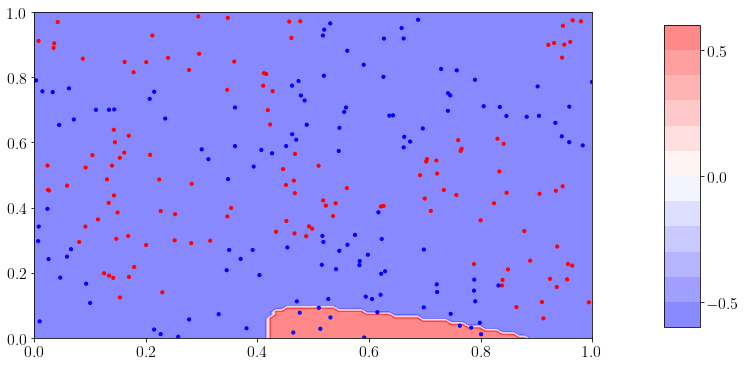

In [2]:
n_test_datapoints = 100
X_test, X1_test, X2_test = create_test_points(0, 1, n_test_datapoints)
fig, ax = plt.subplots(figsize=(10,6))
cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
predictions = bnn.predict(X_test, num_predictions=1000)
predictions = torch.softmax(predictions, dim=-1)
pred_class = torch.argmax(predictions, dim=1)
predictions[:,1] *=-1
map_conf = predictions[torch.arange(predictions.shape[0]), pred_class].reshape(n_test_datapoints, n_test_datapoints)
cax1 = ax.contourf(X1_test, X2_test, map_conf, cmap="bwr", alpha=0.5, levels=10)
cbar = fig.colorbar(cax1, cbar_ax, ticks=[-1, -0.5, 0, 0.5, 1])
ax.scatter(x[:, 0], x[:, 1], c=y, cmap=matplotlib.colors.ListedColormap(["red", "blue"]), s=10)

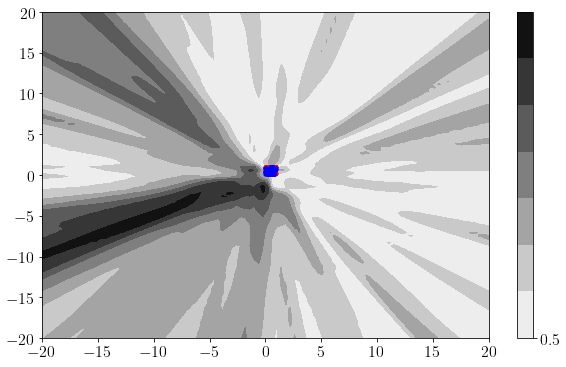

In [3]:
n_test_datapoints = 100
X_test, X1_test, X2_test = create_test_points(-20, 20, n_test_datapoints)
fig, ax = plt.subplots(figsize=(10,6))
predictions = bnn.predict(X_test, num_predictions=1000)
predictions = torch.softmax(predictions, dim=-1)
map_conf = predictions.max(1).values.reshape(n_test_datapoints, n_test_datapoints)
cax1 = ax.contourf(X1_test, X2_test, map_conf, cmap="binary")
cbar = fig.colorbar(cax1, ticks=[0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.scatter(x[:, 0], x[:, 1], c=y, cmap=matplotlib.colors.ListedColormap(["red", "blue"]), s=10)